# Grab every 10th snapshot from 1000 snapshot cache

In [1]:
import math
from simtk import unit
import os
import tempfile
import pickle
import mdtraj as md
import numpy as np
from simtk.unit.quantity import Quantity
import logging 

# Set up logger
_logger = logging.getLogger()
_logger.setLevel(logging.INFO)

from matplotlib import pyplot as plt
from simtk.openmm import app
from tqdm import tqdm, tqdm_notebook
import argparse
import random
import time


In [6]:
def get_dihedrals(i, name, length, out_dir, htf, dihedral_indices_new, dihedral_indices_old):
    
    from tqdm import tqdm
    
    old_top = md.Topology.from_openmm(htf._topology_proposal.old_topology)
    new_top = md.Topology.from_openmm(htf._topology_proposal.new_topology)
    
    # Load nc file
    # From Hannah: https://github.com/hannahbrucemacdonald/endstate_pdbs/blob/master/scripts/input_for_pol_calc.py
    from perses.analysis.utils import open_netcdf
    nc = open_netcdf(os.path.join(out_dir, f"{i}_{phase}_{name.lower()}_{length}ns.nc"))
    nc_checkpoint = open_netcdf(os.path.join(out_dir, f"{i}_{phase}_{name.lower()}_{length}ns_checkpoint.nc"))
    checkpoint_interval = nc_checkpoint.CheckpointInterval
    all_positions = nc_checkpoint.variables['positions']
    n_iter, n_replicas, n_atoms, _ = np.shape(all_positions)

    # Initialize arrays for old, new, and hybrid positions
    all_pos_new = np.zeros(shape=(n_iter, new_top.n_atoms, 3))
    all_pos_old = np.zeros(shape=(n_iter, old_top.n_atoms, 3))
    all_pos_hybrid = np.zeros(shape=(n_iter, n_atoms, 3)) # includes solvent atoms
    
    def new_positions(htf, hybrid_positions):
        n_atoms_new = htf._topology_proposal.n_atoms_new
        hybrid_indices = [htf._new_to_hybrid_map[idx] for idx in range(n_atoms_new)]
        print("shape ", hybrid_positions.shape)
        return hybrid_positions[hybrid_indices, :]
    
    def old_positions(htf, hybrid_positions):
        n_atoms_old = htf._topology_proposal.n_atoms_old
        hybrid_indices = [htf._old_to_hybrid_map[idx] for idx in range(n_atoms_old)]
        return hybrid_positions[hybrid_indices, :]
    
    # Save old, new, and hybrid positions
    for iteration in tqdm(range(n_iter)):
        replica_id = 0
        pos = all_positions[iteration,replica_id,:,:] *unit.nanometers
        print("shape ", pos.shape)
        all_pos_new[iteration] = new_positions(htf, pos).value_in_unit_system(unit.md_unit_system) # Get new positions only
        all_pos_hybrid[iteration] = pos # Get hybrid positions
        all_pos_old[iteration] = old_positions(htf, pos).value_in_unit_system(unit.md_unit_system)

    dihedrals_all = []
    for pos, top, indices in zip([all_pos_new, all_pos_old], [new_top, old_top], [dihedral_indices_new, dihedral_indices_old]):
        traj = md.Trajectory(np.array(pos), top)
        dihedrals = md.compute_dihedrals(traj, np.array([indices]))
        dihedrals_all.append(dihedrals)
    
    return dihedrals_all, n_iter, all_pos_hybrid

def plot_dihedrals(dihedrals, outfile):
    # Plot histogram with error bars : https://stackoverflow.com/questions/35390276/how-to-add-error-bars-to-histogram-diagram-in-python
    entries, edges, _ = plt.hist(dihedrals)
    bin_centers = 0.5 * (edges[:-1] + edges[1:]) # calculate bin centers
    plt.errorbar(bin_centers, entries, yerr=np.sqrt(entries), fmt='r.') # draw errobars, use the sqrt error
    plt.xlim(-np.pi, np.pi)
    plt.show()
#     plt.savefig(outfile, dpi=300)
#     plt.close()
    
def plot_time_series(dihedrals, n_iter, outfile):
    plt.scatter(range(n_iter), dihedrals)
    plt.ylabel("dihedral")
    plt.xlabel("iteration number")
    plt.ylim(-np.pi, np.pi)
    plt.show()
#     plt.savefig(outfile, dpi=300)
#     plt.close()


In [3]:
outdir = "/data/chodera/zhangi/perses_benchmark/neq/14/16/"
endstate = 0
phase = "apo"
length = 1
i = 16
old_aa_name = 'ASN'
new_aa_name = 'TYR'
resid = '501'
name = 'asn'

In [4]:
with open(os.path.join(outdir, f"{i}_{phase}_{endstate}.pickle"), 'rb') as f:
    htf = pickle.load(f)


In [5]:
thr_dihedral = ['N', 'CA', 'CB', 'OG1']
other_dihedral = ['N', 'CA', 'CB', 'CG']
ala_dihedral = ['N', 'CA', 'CB', 'HB1']
asp_dihedral = ['CA', 'CB', 'CG', 'OD2']
ile_dihedral = ['N', 'CA', 'CB', 'CG2']

dihedral_atoms = []
for aa_name in [old_aa_name, new_aa_name]:
    if aa_name in ["PHE", "TYR", "TRP", "GLU", "LYS", "ARG", "GLN", "ASN"]:
        dihedral_atoms.append(other_dihedral)
    elif aa_name == "THR":
        dihedral_atoms.append(thr_dihedral)
    elif aa_name == "ALA":
        dihedral_atoms.append(ala_dihedral)
    elif aa_name == 'ASP':
        dihedral_atoms.append(asp_dihedral)
    elif aa_name == 'ILE':
        dihedral_atoms.append(ile_dihedral)
        

for res in htf._topology_proposal.old_topology.residues():
    if res.id == resid and res.chain.index == 0:
        residue_old = res
for res in htf._topology_proposal.new_topology.residues():
    if res.id == resid and res.chain.index == 0:
        residue_new = res
# indices_old = [atom.index for atom in list(htf._topology_proposal.old_topology.residues())[int(args.resid)].atoms() if atom.name in dihedral_atoms[0]]
# indices_new = [atom.index for atom in list(htf._topology_proposal.new_topology.residues())[int(args.resid)].atoms() if atom.name in dihedral_atoms[1]]
indices_old = [atom.index for atom in residue_old.atoms() if atom.name in dihedral_atoms[0]]
indices_new = [atom.index for atom in residue_new.atoms() if atom.name in dihedral_atoms[1]]
_logger.info(f"old indices: {indices_old}")
_logger.info(f"new indices: {indices_new}")



INFO:root:old indices: [2605, 2607, 2609, 2612]
INFO:root:new indices: [2605, 2607, 2609, 2612]


In [7]:
dihedrals, n_iter, all_pos_hybrid = get_dihedrals(i, name, length, outdir, htf, indices_new, indices_old)


  0%|          | 2/1001 [00:00<01:23, 12.02it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


  0%|          | 4/1001 [00:00<01:20, 12.43it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


  1%|          | 8/1001 [00:00<01:17, 12.74it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


  1%|          | 10/1001 [00:00<01:17, 12.78it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


  1%|▏         | 14/1001 [00:01<01:16, 12.97it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


  2%|▏         | 16/1001 [00:01<01:19, 12.38it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


  2%|▏         | 20/1001 [00:01<01:16, 12.75it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


  2%|▏         | 22/1001 [00:01<01:16, 12.77it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


  3%|▎         | 26/1001 [00:02<01:15, 12.95it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


  3%|▎         | 28/1001 [00:02<01:15, 12.90it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


  3%|▎         | 32/1001 [00:02<01:14, 12.97it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


  3%|▎         | 34/1001 [00:02<01:15, 12.88it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


  4%|▍         | 38/1001 [00:02<01:14, 12.87it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


  4%|▍         | 40/1001 [00:03<01:14, 12.85it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


  4%|▍         | 44/1001 [00:03<01:13, 12.95it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


  5%|▍         | 46/1001 [00:03<01:13, 12.93it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


  5%|▍         | 50/1001 [00:03<01:12, 13.03it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


  5%|▌         | 52/1001 [00:04<01:12, 13.02it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


  6%|▌         | 56/1001 [00:04<01:12, 13.03it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


  6%|▌         | 58/1001 [00:04<01:12, 13.01it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


  6%|▌         | 62/1001 [00:04<01:11, 13.08it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


  6%|▋         | 64/1001 [00:04<01:12, 13.00it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


  7%|▋         | 68/1001 [00:05<01:11, 13.08it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


  7%|▋         | 70/1001 [00:05<01:12, 12.91it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


  7%|▋         | 74/1001 [00:05<01:11, 12.96it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


  8%|▊         | 76/1001 [00:05<01:11, 13.01it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


  8%|▊         | 80/1001 [00:06<01:10, 12.99it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


  8%|▊         | 82/1001 [00:06<01:10, 13.02it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


  9%|▊         | 86/1001 [00:06<01:10, 13.02it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


  9%|▉         | 88/1001 [00:06<01:09, 13.09it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


  9%|▉         | 92/1001 [00:07<01:09, 13.08it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


  9%|▉         | 94/1001 [00:07<01:09, 13.08it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 10%|▉         | 98/1001 [00:07<01:09, 13.04it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 10%|▉         | 100/1001 [00:07<01:09, 12.95it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 10%|█         | 104/1001 [00:08<01:09, 13.00it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 11%|█         | 106/1001 [00:08<01:08, 13.02it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 11%|█         | 110/1001 [00:08<01:08, 13.01it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 11%|█         | 112/1001 [00:08<01:08, 12.99it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 12%|█▏        | 116/1001 [00:08<01:07, 13.02it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 12%|█▏        | 118/1001 [00:09<01:07, 12.99it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 12%|█▏        | 122/1001 [00:09<01:07, 13.03it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 12%|█▏        | 124/1001 [00:09<01:07, 13.04it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 13%|█▎        | 128/1001 [00:09<01:07, 12.99it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 13%|█▎        | 130/1001 [00:10<01:07, 12.98it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 13%|█▎        | 134/1001 [00:10<01:07, 12.94it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 14%|█▎        | 136/1001 [00:10<01:07, 12.89it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 14%|█▍        | 140/1001 [00:10<01:06, 13.01it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 14%|█▍        | 142/1001 [00:10<01:06, 12.92it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 15%|█▍        | 146/1001 [00:11<01:05, 13.06it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 15%|█▍        | 148/1001 [00:11<01:05, 12.98it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 15%|█▌        | 152/1001 [00:11<01:05, 13.06it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 15%|█▌        | 154/1001 [00:11<01:05, 12.84it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 16%|█▌        | 158/1001 [00:12<01:04, 12.97it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 16%|█▌        | 160/1001 [00:12<01:05, 12.88it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 16%|█▋        | 164/1001 [00:12<01:04, 12.88it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 17%|█▋        | 166/1001 [00:12<01:04, 12.87it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 17%|█▋        | 170/1001 [00:13<01:03, 12.99it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 17%|█▋        | 172/1001 [00:13<01:04, 12.93it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 18%|█▊        | 176/1001 [00:13<01:03, 13.01it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 18%|█▊        | 178/1001 [00:13<01:03, 12.94it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 18%|█▊        | 182/1001 [00:14<01:02, 13.05it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 18%|█▊        | 184/1001 [00:14<01:02, 13.00it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 19%|█▉        | 188/1001 [00:14<01:01, 13.12it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 19%|█▉        | 190/1001 [00:14<01:02, 13.02it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 19%|█▉        | 194/1001 [00:14<01:02, 12.97it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 20%|█▉        | 196/1001 [00:15<01:02, 12.96it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 20%|█▉        | 200/1001 [00:15<01:01, 13.03it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 20%|██        | 202/1001 [00:15<01:01, 13.01it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 21%|██        | 206/1001 [00:15<01:00, 13.03it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 21%|██        | 208/1001 [00:16<01:00, 13.02it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 21%|██        | 212/1001 [00:16<01:01, 12.77it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 21%|██▏       | 214/1001 [00:16<01:01, 12.86it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 22%|██▏       | 218/1001 [00:16<01:00, 12.87it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 22%|██▏       | 220/1001 [00:17<01:00, 12.90it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 22%|██▏       | 224/1001 [00:17<00:59, 12.97it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 23%|██▎       | 226/1001 [00:17<01:00, 12.80it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 23%|██▎       | 230/1001 [00:17<00:59, 12.96it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 23%|██▎       | 232/1001 [00:17<00:59, 13.01it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 24%|██▎       | 236/1001 [00:18<00:58, 13.05it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 24%|██▍       | 238/1001 [00:18<00:58, 13.06it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 24%|██▍       | 242/1001 [00:18<00:58, 13.08it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 24%|██▍       | 244/1001 [00:18<00:57, 13.13it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 25%|██▍       | 248/1001 [00:19<00:57, 13.07it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 25%|██▍       | 250/1001 [00:19<00:57, 13.07it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 25%|██▌       | 254/1001 [00:19<00:57, 13.00it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 26%|██▌       | 256/1001 [00:19<00:56, 13.10it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 26%|██▌       | 260/1001 [00:20<00:57, 12.94it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 26%|██▌       | 262/1001 [00:20<00:57, 12.89it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 27%|██▋       | 266/1001 [00:20<00:56, 12.98it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 27%|██▋       | 268/1001 [00:20<00:56, 12.90it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 27%|██▋       | 272/1001 [00:21<00:56, 12.95it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 27%|██▋       | 274/1001 [00:21<00:56, 12.86it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 28%|██▊       | 278/1001 [00:21<00:55, 12.97it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 28%|██▊       | 280/1001 [00:21<00:55, 12.96it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 28%|██▊       | 284/1001 [00:21<00:55, 12.95it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 29%|██▊       | 286/1001 [00:22<00:55, 12.93it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 29%|██▉       | 290/1001 [00:22<00:55, 12.82it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 29%|██▉       | 292/1001 [00:22<00:55, 12.79it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 30%|██▉       | 296/1001 [00:22<00:54, 12.93it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 30%|██▉       | 298/1001 [00:23<00:54, 12.86it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 30%|███       | 302/1001 [00:23<00:53, 12.98it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 30%|███       | 304/1001 [00:23<00:54, 12.90it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 31%|███       | 308/1001 [00:23<00:53, 12.99it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 31%|███       | 310/1001 [00:23<00:53, 12.93it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 31%|███▏      | 314/1001 [00:24<00:53, 12.94it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 32%|███▏      | 316/1001 [00:24<00:53, 12.83it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 32%|███▏      | 320/1001 [00:24<00:53, 12.79it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 32%|███▏      | 322/1001 [00:24<00:53, 12.75it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 33%|███▎      | 326/1001 [00:25<00:52, 12.88it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 33%|███▎      | 328/1001 [00:25<00:52, 12.80it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 33%|███▎      | 332/1001 [00:25<00:51, 12.88it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 33%|███▎      | 334/1001 [00:25<00:52, 12.81it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 34%|███▍      | 338/1001 [00:26<00:51, 12.90it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 34%|███▍      | 340/1001 [00:26<00:51, 12.81it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 34%|███▍      | 344/1001 [00:26<00:51, 12.86it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 35%|███▍      | 346/1001 [00:26<00:51, 12.71it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 35%|███▍      | 350/1001 [00:27<00:51, 12.68it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 35%|███▌      | 352/1001 [00:27<00:51, 12.64it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 36%|███▌      | 356/1001 [00:27<00:50, 12.78it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 36%|███▌      | 358/1001 [00:27<00:50, 12.73it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 36%|███▌      | 362/1001 [00:28<00:49, 12.83it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 36%|███▋      | 364/1001 [00:28<00:49, 12.80it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 37%|███▋      | 368/1001 [00:28<00:49, 12.77it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 37%|███▋      | 370/1001 [00:28<00:49, 12.80it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 37%|███▋      | 374/1001 [00:28<00:48, 12.82it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 38%|███▊      | 376/1001 [00:29<00:48, 12.83it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 38%|███▊      | 380/1001 [00:29<00:48, 12.84it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 38%|███▊      | 382/1001 [00:29<00:48, 12.67it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 39%|███▊      | 386/1001 [00:29<00:48, 12.71it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 39%|███▉      | 388/1001 [00:30<00:47, 12.78it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 39%|███▉      | 392/1001 [00:30<00:47, 12.70it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 39%|███▉      | 394/1001 [00:30<00:47, 12.70it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 40%|███▉      | 398/1001 [00:30<00:47, 12.60it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 40%|███▉      | 400/1001 [00:31<00:48, 12.43it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 40%|████      | 404/1001 [00:31<00:46, 12.72it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 41%|████      | 406/1001 [00:31<00:46, 12.73it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 41%|████      | 410/1001 [00:31<00:46, 12.81it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 41%|████      | 412/1001 [00:31<00:46, 12.76it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 42%|████▏     | 416/1001 [00:32<00:45, 12.74it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 42%|████▏     | 418/1001 [00:32<00:45, 12.70it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 42%|████▏     | 422/1001 [00:32<00:45, 12.78it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 42%|████▏     | 424/1001 [00:32<00:45, 12.72it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 43%|████▎     | 428/1001 [00:33<00:44, 12.82it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 43%|████▎     | 430/1001 [00:33<00:44, 12.79it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 43%|████▎     | 434/1001 [00:33<00:43, 12.91it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 44%|████▎     | 436/1001 [00:33<00:44, 12.83it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 44%|████▍     | 440/1001 [00:34<00:43, 12.87it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 44%|████▍     | 442/1001 [00:34<00:43, 12.78it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 45%|████▍     | 446/1001 [00:34<00:43, 12.77it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 45%|████▍     | 448/1001 [00:34<00:43, 12.75it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 45%|████▌     | 452/1001 [00:35<00:42, 12.91it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 45%|████▌     | 454/1001 [00:35<00:42, 12.89it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 46%|████▌     | 458/1001 [00:35<00:42, 12.91it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 46%|████▌     | 460/1001 [00:35<00:41, 12.91it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 46%|████▋     | 464/1001 [00:36<00:41, 12.95it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 47%|████▋     | 466/1001 [00:36<00:41, 12.97it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 47%|████▋     | 470/1001 [00:36<00:40, 12.99it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 47%|████▋     | 472/1001 [00:36<00:41, 12.88it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 48%|████▊     | 476/1001 [00:36<00:40, 12.87it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 48%|████▊     | 478/1001 [00:37<00:41, 12.67it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 48%|████▊     | 482/1001 [00:37<00:40, 12.66it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 48%|████▊     | 484/1001 [00:37<00:40, 12.74it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 49%|████▉     | 488/1001 [00:37<00:40, 12.72it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 49%|████▉     | 490/1001 [00:38<00:39, 12.79it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 49%|████▉     | 494/1001 [00:38<00:39, 12.77it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 50%|████▉     | 496/1001 [00:38<00:39, 12.78it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 50%|████▉     | 500/1001 [00:38<00:39, 12.75it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 50%|█████     | 502/1001 [00:38<00:38, 12.80it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 51%|█████     | 506/1001 [00:39<00:38, 12.71it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 51%|█████     | 508/1001 [00:39<00:38, 12.79it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 51%|█████     | 512/1001 [00:39<00:38, 12.74it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 51%|█████▏    | 514/1001 [00:39<00:38, 12.66it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 52%|█████▏    | 518/1001 [00:40<00:37, 12.84it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 52%|█████▏    | 520/1001 [00:40<00:37, 12.74it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 52%|█████▏    | 524/1001 [00:40<00:36, 13.00it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 53%|█████▎    | 526/1001 [00:40<00:36, 13.00it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 53%|█████▎    | 530/1001 [00:41<00:36, 13.06it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 53%|█████▎    | 532/1001 [00:41<00:36, 12.90it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 54%|█████▎    | 536/1001 [00:41<00:35, 12.99it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 54%|█████▎    | 538/1001 [00:41<00:36, 12.82it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 54%|█████▍    | 542/1001 [00:42<00:35, 12.76it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 54%|█████▍    | 544/1001 [00:42<00:35, 12.75it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 55%|█████▍    | 548/1001 [00:42<00:35, 12.90it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 55%|█████▍    | 550/1001 [00:42<00:35, 12.86it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 55%|█████▌    | 554/1001 [00:43<00:34, 12.96it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 56%|█████▌    | 556/1001 [00:43<00:34, 12.96it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 56%|█████▌    | 560/1001 [00:43<00:33, 13.05it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 56%|█████▌    | 562/1001 [00:43<00:33, 13.06it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 57%|█████▋    | 566/1001 [00:43<00:33, 13.07it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 57%|█████▋    | 568/1001 [00:44<00:33, 13.02it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 57%|█████▋    | 572/1001 [00:44<00:32, 13.06it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 57%|█████▋    | 574/1001 [00:44<00:33, 12.87it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 58%|█████▊    | 578/1001 [00:44<00:32, 12.95it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 58%|█████▊    | 580/1001 [00:45<00:32, 12.97it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 58%|█████▊    | 584/1001 [00:45<00:32, 12.98it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 59%|█████▊    | 586/1001 [00:45<00:31, 13.03it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 59%|█████▉    | 590/1001 [00:45<00:31, 13.01it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 59%|█████▉    | 592/1001 [00:45<00:31, 13.01it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 60%|█████▉    | 596/1001 [00:46<00:31, 13.02it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 60%|█████▉    | 598/1001 [00:46<00:30, 13.12it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 60%|██████    | 602/1001 [00:46<00:30, 12.99it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 60%|██████    | 604/1001 [00:46<00:30, 13.06it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 61%|██████    | 608/1001 [00:47<00:30, 12.98it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 61%|██████    | 610/1001 [00:47<00:30, 12.94it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 61%|██████▏   | 614/1001 [00:47<00:29, 13.01it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 62%|██████▏   | 616/1001 [00:47<00:29, 12.96it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 62%|██████▏   | 620/1001 [00:48<00:29, 13.07it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 62%|██████▏   | 622/1001 [00:48<00:29, 12.96it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 63%|██████▎   | 626/1001 [00:48<00:28, 13.08it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 63%|██████▎   | 628/1001 [00:48<00:28, 12.98it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 63%|██████▎   | 632/1001 [00:49<00:28, 13.02it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 63%|██████▎   | 634/1001 [00:49<00:28, 12.96it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 64%|██████▎   | 638/1001 [00:49<00:28, 12.94it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 64%|██████▍   | 640/1001 [00:49<00:28, 12.89it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 64%|██████▍   | 644/1001 [00:49<00:27, 13.02it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 65%|██████▍   | 646/1001 [00:50<00:27, 12.93it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 65%|██████▍   | 650/1001 [00:50<00:26, 13.03it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 65%|██████▌   | 652/1001 [00:50<00:26, 12.96it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 66%|██████▌   | 656/1001 [00:50<00:26, 13.02it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 66%|██████▌   | 658/1001 [00:51<00:26, 12.97it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 66%|██████▌   | 662/1001 [00:51<00:26, 13.02it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 66%|██████▋   | 664/1001 [00:51<00:26, 12.94it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 67%|██████▋   | 668/1001 [00:51<00:25, 12.91it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 67%|██████▋   | 670/1001 [00:51<00:25, 12.94it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 67%|██████▋   | 674/1001 [00:52<00:25, 13.01it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 68%|██████▊   | 676/1001 [00:52<00:24, 13.01it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 68%|██████▊   | 680/1001 [00:52<00:24, 13.01it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 68%|██████▊   | 682/1001 [00:52<00:24, 13.01it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 69%|██████▊   | 686/1001 [00:53<00:24, 13.05it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 69%|██████▊   | 688/1001 [00:53<00:24, 13.03it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 69%|██████▉   | 692/1001 [00:53<00:23, 13.09it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 69%|██████▉   | 694/1001 [00:53<00:23, 13.03it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 70%|██████▉   | 698/1001 [00:54<00:23, 13.02it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 70%|██████▉   | 700/1001 [00:54<00:23, 12.87it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 70%|███████   | 704/1001 [00:54<00:23, 12.87it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 71%|███████   | 706/1001 [00:54<00:22, 12.96it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 71%|███████   | 710/1001 [00:55<00:22, 12.92it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 71%|███████   | 712/1001 [00:55<00:22, 12.98it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 72%|███████▏  | 716/1001 [00:55<00:21, 12.96it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 72%|███████▏  | 718/1001 [00:55<00:21, 12.97it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 72%|███████▏  | 722/1001 [00:55<00:21, 12.94it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 72%|███████▏  | 724/1001 [00:56<00:21, 13.00it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 73%|███████▎  | 728/1001 [00:56<00:21, 12.96it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 73%|███████▎  | 730/1001 [00:56<00:20, 12.95it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 73%|███████▎  | 734/1001 [00:56<00:20, 12.89it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 74%|███████▎  | 736/1001 [00:57<00:20, 12.93it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 74%|███████▍  | 740/1001 [00:57<00:20, 12.80it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 74%|███████▍  | 742/1001 [00:57<00:20, 12.76it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 75%|███████▍  | 746/1001 [00:57<00:19, 12.85it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 75%|███████▍  | 748/1001 [00:57<00:19, 12.95it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 75%|███████▌  | 752/1001 [00:58<00:19, 12.87it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 75%|███████▌  | 754/1001 [00:58<00:19, 12.78it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 76%|███████▌  | 758/1001 [00:58<00:18, 12.85it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 76%|███████▌  | 760/1001 [00:58<00:18, 12.84it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 76%|███████▋  | 764/1001 [00:59<00:18, 13.00it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 77%|███████▋  | 766/1001 [00:59<00:18, 12.92it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 77%|███████▋  | 770/1001 [00:59<00:17, 13.04it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 77%|███████▋  | 772/1001 [00:59<00:17, 12.96it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 78%|███████▊  | 776/1001 [01:00<00:17, 13.08it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 78%|███████▊  | 778/1001 [01:00<00:17, 13.01it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 78%|███████▊  | 782/1001 [01:00<00:16, 13.00it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 78%|███████▊  | 784/1001 [01:00<00:16, 12.96it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 79%|███████▊  | 788/1001 [01:01<00:16, 12.95it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 79%|███████▉  | 790/1001 [01:01<00:16, 12.89it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 79%|███████▉  | 794/1001 [01:01<00:16, 12.20it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 80%|███████▉  | 796/1001 [01:01<00:21,  9.74it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 80%|███████▉  | 799/1001 [01:02<00:25,  8.04it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 80%|████████  | 802/1001 [01:02<00:21,  9.46it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 80%|████████  | 804/1001 [01:02<00:18, 10.43it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 81%|████████  | 808/1001 [01:03<00:16, 11.66it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 81%|████████  | 810/1001 [01:03<00:15, 12.03it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 81%|████████▏ | 814/1001 [01:03<00:15, 12.43it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 82%|████████▏ | 816/1001 [01:03<00:14, 12.54it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 82%|████████▏ | 820/1001 [01:04<00:14, 12.86it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 82%|████████▏ | 822/1001 [01:04<00:13, 12.85it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 83%|████████▎ | 826/1001 [01:04<00:13, 13.01it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 83%|████████▎ | 828/1001 [01:04<00:13, 12.97it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 83%|████████▎ | 832/1001 [01:04<00:12, 13.06it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 83%|████████▎ | 834/1001 [01:05<00:12, 13.00it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 84%|████████▎ | 838/1001 [01:05<00:12, 13.09it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 84%|████████▍ | 840/1001 [01:05<00:12, 12.98it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 84%|████████▍ | 844/1001 [01:05<00:12, 12.92it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 85%|████████▍ | 846/1001 [01:06<00:11, 12.95it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 85%|████████▍ | 850/1001 [01:06<00:11, 13.05it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 85%|████████▌ | 852/1001 [01:06<00:11, 13.00it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 86%|████████▌ | 856/1001 [01:06<00:11, 13.08it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 86%|████████▌ | 858/1001 [01:06<00:10, 13.07it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 86%|████████▌ | 862/1001 [01:07<00:10, 13.11it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 86%|████████▋ | 864/1001 [01:07<00:10, 13.06it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 87%|████████▋ | 868/1001 [01:07<00:10, 13.12it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 87%|████████▋ | 870/1001 [01:07<00:10, 13.06it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 87%|████████▋ | 874/1001 [01:08<00:09, 13.09it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 88%|████████▊ | 876/1001 [01:08<00:09, 12.93it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 88%|████████▊ | 880/1001 [01:08<00:09, 12.98it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 88%|████████▊ | 882/1001 [01:08<00:09, 13.03it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 89%|████████▊ | 886/1001 [01:09<00:08, 12.99it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 89%|████████▊ | 888/1001 [01:09<00:08, 13.01it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 89%|████████▉ | 892/1001 [01:09<00:08, 13.00it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 89%|████████▉ | 894/1001 [01:09<00:08, 13.04it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 90%|████████▉ | 898/1001 [01:10<00:07, 13.00it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 90%|████████▉ | 900/1001 [01:10<00:07, 13.02it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 90%|█████████ | 904/1001 [01:10<00:07, 13.02it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 91%|█████████ | 906/1001 [01:10<00:07, 12.82it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 91%|█████████ | 910/1001 [01:10<00:07, 12.93it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 91%|█████████ | 912/1001 [01:11<00:06, 12.95it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 92%|█████████▏| 916/1001 [01:11<00:06, 12.96it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 92%|█████████▏| 918/1001 [01:11<00:06, 13.00it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 92%|█████████▏| 922/1001 [01:11<00:06, 13.03it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 92%|█████████▏| 924/1001 [01:12<00:05, 13.04it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 93%|█████████▎| 928/1001 [01:12<00:05, 13.05it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 93%|█████████▎| 930/1001 [01:12<00:05, 13.08it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 93%|█████████▎| 934/1001 [01:12<00:05, 13.00it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 94%|█████████▎| 936/1001 [01:12<00:04, 13.05it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 94%|█████████▍| 940/1001 [01:13<00:04, 12.97it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 94%|█████████▍| 942/1001 [01:13<00:04, 12.89it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 95%|█████████▍| 946/1001 [01:13<00:04, 13.01it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 95%|█████████▍| 948/1001 [01:13<00:04, 12.95it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 95%|█████████▌| 952/1001 [01:14<00:03, 13.07it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 95%|█████████▌| 954/1001 [01:14<00:03, 12.99it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 96%|█████████▌| 958/1001 [01:14<00:03, 13.07it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 96%|█████████▌| 960/1001 [01:14<00:03, 13.03it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 96%|█████████▋| 964/1001 [01:15<00:02, 12.92it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 97%|█████████▋| 966/1001 [01:15<00:02, 12.89it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 97%|█████████▋| 970/1001 [01:15<00:02, 12.88it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 97%|█████████▋| 972/1001 [01:15<00:02, 12.82it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 98%|█████████▊| 976/1001 [01:16<00:01, 13.00it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 98%|█████████▊| 978/1001 [01:16<00:01, 12.93it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 98%|█████████▊| 982/1001 [01:16<00:01, 13.07it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 98%|█████████▊| 984/1001 [01:16<00:01, 12.99it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 99%|█████████▊| 988/1001 [01:16<00:00, 13.00it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 99%|█████████▉| 990/1001 [01:17<00:00, 12.87it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


 99%|█████████▉| 994/1001 [01:17<00:00, 12.95it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


100%|█████████▉| 996/1001 [01:17<00:00, 12.82it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


100%|█████████▉| 1000/1001 [01:17<00:00, 12.89it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


100%|██████████| 1001/1001 [01:17<00:00, 12.84it/s]


In [8]:
# Plot 
dihedrals_new = dihedrals[0]
dihedrals_old = dihedrals[1]


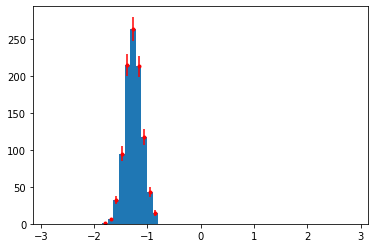

In [12]:
plot_dihedrals(dihedrals_old, os.path.join(outdir, f"{i}_{phase}_{name.lower()}_{length}ns_{old_aa_name.lower()}_correlated.png"))


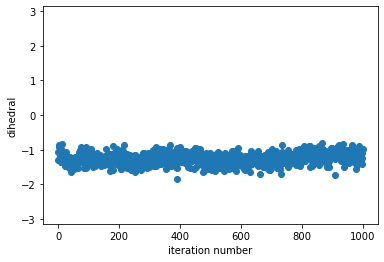

In [13]:
plot_time_series(dihedrals_old, n_iter, os.path.join(outdir, f"{i}_{phase}_{name.lower()}_{length}ns_{old_aa_name.lower()}_timeseries.png"))


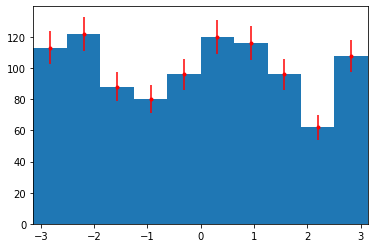

In [14]:
plot_dihedrals(dihedrals_new, os.path.join(outdir, f"{i}_{phase}_{name.lower()}_{length}ns_{new_aa_name.lower()}_correlated.png"))


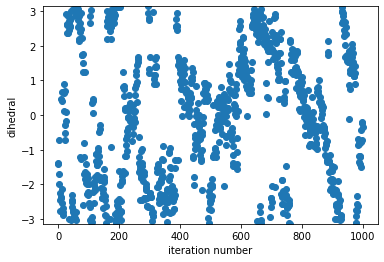

In [15]:
plot_time_series(dihedrals_new, n_iter, os.path.join(outdir, f"{i}_{phase}_{name.lower()}_{length}ns_{new_aa_name.lower()}_timeseries.png"))


In [19]:
all_pos_hybrid[1::10].shape

(100, 58648, 3)

In [25]:
x = list(range(21))

In [26]:
x

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [28]:
x[1::10]

[1, 11]

## N501Y 14/22 apo at lambda = 1 (TYR)

This one is only loading as 3 iterations..?

In [29]:
outdir = "/data/chodera/zhangi/perses_benchmark/neq/14/22/"
endstate = 1
phase = "apo"
length = 1
i = 22
old_aa_name = 'ASN'
new_aa_name = 'TYR'
resid = '501'
name = 'tyr'

In [30]:
with open(os.path.join(outdir, f"{i}_{phase}_{endstate}.pickle"), 'rb') as f:
    htf = pickle.load(f)


In [31]:
thr_dihedral = ['N', 'CA', 'CB', 'OG1']
other_dihedral = ['N', 'CA', 'CB', 'CG']
ala_dihedral = ['N', 'CA', 'CB', 'HB1']
asp_dihedral = ['CA', 'CB', 'CG', 'OD2']
ile_dihedral = ['N', 'CA', 'CB', 'CG2']

dihedral_atoms = []
for aa_name in [old_aa_name, new_aa_name]:
    if aa_name in ["PHE", "TYR", "TRP", "GLU", "LYS", "ARG", "GLN", "ASN"]:
        dihedral_atoms.append(other_dihedral)
    elif aa_name == "THR":
        dihedral_atoms.append(thr_dihedral)
    elif aa_name == "ALA":
        dihedral_atoms.append(ala_dihedral)
    elif aa_name == 'ASP':
        dihedral_atoms.append(asp_dihedral)
    elif aa_name == 'ILE':
        dihedral_atoms.append(ile_dihedral)
        

for res in htf._topology_proposal.old_topology.residues():
    if res.id == resid and res.chain.index == 0:
        residue_old = res
for res in htf._topology_proposal.new_topology.residues():
    if res.id == resid and res.chain.index == 0:
        residue_new = res
# indices_old = [atom.index for atom in list(htf._topology_proposal.old_topology.residues())[int(args.resid)].atoms() if atom.name in dihedral_atoms[0]]
# indices_new = [atom.index for atom in list(htf._topology_proposal.new_topology.residues())[int(args.resid)].atoms() if atom.name in dihedral_atoms[1]]
indices_old = [atom.index for atom in residue_old.atoms() if atom.name in dihedral_atoms[0]]
indices_new = [atom.index for atom in residue_new.atoms() if atom.name in dihedral_atoms[1]]
_logger.info(f"old indices: {indices_old}")
_logger.info(f"new indices: {indices_new}")



INFO:root:old indices: [2605, 2607, 2609, 2612]
INFO:root:new indices: [2605, 2607, 2609, 2612]


In [32]:
dihedrals, n_iter, all_pos_hybrid = get_dihedrals(i, name, length, outdir, htf, indices_new, indices_old)


 67%|██████▋   | 2/3 [00:00<00:00, 13.57it/s]

shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)
shape  (58648, 3)


100%|██████████| 3/3 [00:00<00:00, 13.17it/s]


In [34]:
from perses.analysis.utils import open_netcdf
nc = open_netcdf(os.path.join(outdir, f"{i}_{phase}_{name.lower()}_{length}ns.nc"))
nc_checkpoint = open_netcdf(os.path.join(outdir, f"{i}_{phase}_{name.lower()}_{length}ns_checkpoint.nc"))
checkpoint_interval = nc_checkpoint.CheckpointInterval
all_positions = nc_checkpoint.variables['positions']
n_iter, n_replicas, n_atoms, _ = np.shape(all_positions)

In [36]:
all_positions.shape

(3, 1, 58648, 3)

In [39]:
nc.variables

{'last_iteration': <class 'netCDF4._netCDF4.Variable'>
 int64 last_iteration(scalar)
 unlimited dimensions: 
 current shape = (1,)
 filling on, default _FillValue of -9223372036854775806 used,
 'analysis_particle_indices': <class 'netCDF4._netCDF4.Variable'>
 int64 analysis_particle_indices(analysis_particles)
     long_name: analysis_particle_indices[analysis_particles] is the indices of the particles with extra information stored about them in theanalysis file.
 unlimited dimensions: analysis_particles
 current shape = (0,)
 filling on, default _FillValue of -9223372036854775806 used,
 'options': <class 'netCDF4._netCDF4.Variable'>
 vlen options(scalar)
 vlen data type: <class 'str'>
 unlimited dimensions: 
 current shape = (1,),
 'metadata': <class 'netCDF4._netCDF4.Variable'>
 |S1 metadata(fixedL3)
 unlimited dimensions: 
 current shape = (3,)
 filling on, default _FillValue of   used,
 'states': <class 'netCDF4._netCDF4.Variable'>
 int32 states(iteration, replica)
     units: none